![](https://drive.google.com/uc?export=view&id=1NiRkCapP04t7XxA7fbG7ZWie2PA1L_0M)


# **Complejidad y sobreajuste**
---

En este _notebook_ exploraremos la diferencia entre parámetros e hiperparámetros de un modelo de aprendizaje computacional, además de conceptos como la capacidad o complejidad, y las consecuencias del subajuste y sobreajuste.

Para esto, observaremos cómo se comporta la complejidad del modelo de clasificación no lineal  *k-vecinos más cercanos* (K-nearest neighbors en inglés).


# **1. Dependencias**
---
Importamos las librerías necesarias y definimos algunas funciones básicas de visualización que vamos a usar en algunos ejemplos. 


### **1.1. Dependencias**
---
Para la construcción de modelos y ejecución de procedimientos metodológicos de aprendizaje automático, utilizaremos la librería **Scikit-learn** (**`sklearn`**) y varias de sus funciones y conjuntos de datos.

In [ ]:
# Actualizamos scikit-learn a la última versión
!pip install -U scikit-learn 

# Importamos scikit-learn 
import sklearn

     |████████████████████████████████| 22.3MB 3.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# Librerías básicas de análisis y visualización de datos.
import numpy as np  
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Configuraciones para las librerías y módulos usados

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Este material se realizó con las siguientes versiones:
*  *Python*: 3.7.10
*  *Scikit-learn*: 0.24.1
*  *NumPy*:  1.19.5
*  *Pandas*:  1.1.5
*  *Matplotlib*:  3.2.2
*  *Seaborn*:  0.11.1

In [ ]:
# Versión de Python y las demás librerías.
!python --version
print('Scikit-learn', sklearn.__version__)
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)

Python 3.7.10
Scikit-learn 0.24.1
NumPy 1.19.5
Pandas 1.1.5
Matplotlib 3.2.2
Seaborn 0.11.1


### **1.2. Funciones de utilidad y visualización**
---

Para ilustrar los ejemplos discutidos en este material utilizaremos algunas funciones que permiten visualizar de manera general los datos y conceptos discutidos en las secciones.

> **Nota**: *Matplotlib* y *Seaborn* se encuentran por fuera del alcance de este módulo. No es necesario que entienda estas funciones en detalle para sacar partido del resto del contenido puesto a su disposición. Usted decide si leer o no estas funciones en profundidad. Si decide omitir esta sección, continúe directamente con la siguiente sección, en donde se discutirán los conjuntos de datos que vamos a utilizar.

In [ ]:
# Función para visualizar un conjunto de datos de dos variables en un plano 2D
def plot_data(X, y, model = None, ax = None, title=None):

    if ax is None:
      _, ax = plt.subplots(dpi = 110)

    if model is not None: 
      pred_fun = gen_pred_fun(model)
      plot_decision_region(X, pred_fun, ax)

    y_unique = np.unique(y)    
    df = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'Clases': y})
    sns.set_theme()
    sns.scatterplot(data = df, x = 'x1', y = 'x2', 
                    hue = 'Clases',style = 'Clases', ax = ax, palette = 'Set1').set_title(title)

In [ ]:
# Función para visualizar la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun, ax=None):
    min_x, max_x = np.min(X[:, 0]), np.max(X[:, 0])
    min_y, max_y = np.min(X[:, 1]), np.max(X[:, 1])
 
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05

    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)

    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape

    ZZ = np.zeros((grid_r, grid_c))

    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])    

    ax.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm_r, vmin= -1, vmax=2, alpha = 0.75)    
    ax.set_xlabel("x")
    ax.set_ylabel("y")

In [ ]:
# Función para visualizar la curva de aprendizaje a partir 
# del error de entrenamiento y de generalización.
def plot_learning_curve(train_error, generalization_error):
  
  balance_point = np.array(generalization_error).argmin() + 1
  plt.figure(figsize = (8, 5), dpi = 105)

  plt.plot(range(1, k_values + 1), train_error, label="Entrenamiento")
  plt.plot(range(1, k_values + 1), generalization_error, label="Validación")
  plt.xticks(range(0, k_values + 1, 5))
  plt.xlabel("k-vecinos")
  plt.ylabel("Error")
  y_min, y_max = plt.gca().get_ylim() 
  plt.vlines(balance_point, y_min, y_max, colors = ['red'], linestyles = ['dashdot'])
  plt.ylim([y_min, y_max])
  plt.text(balance_point + 1, 0.165, 'Punto de balance')
  plt.legend();

In [ ]:
#Función para generar la función de predicción de un clasificador entrenado previamente.
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

# **2. Definición del conjunto de datos**
---

En este material vamos a trabajar con un conjunto de datos artificial. El conjunto es creado usando la función **`make_moons`** de _Scikit-Learn_. Esta función permite introducir algo de ruido sobre las muestras creadas con el argumento **`noise`**.

In [ ]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=1000, noise=0.4, random_state=0)

In [ ]:
print('X ~ n_muestras x n_características:', X.shape)
print('y ~ n_muestras:', y.shape)

print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:', y[:5])

X ~ n_muestras x n_características: (1000, 2)
y ~ n_muestras: (1000,)

Primeras 5 muestras:
 [[ 2.17300137  0.68579369]
 [ 1.97315415  0.28555497]
 [-0.15360193  0.194076  ]
 [-0.55760668  0.20288223]
 [ 0.32028022 -0.44518473]]

Primeras 5 etiquetas: [1 1 0 1 1]


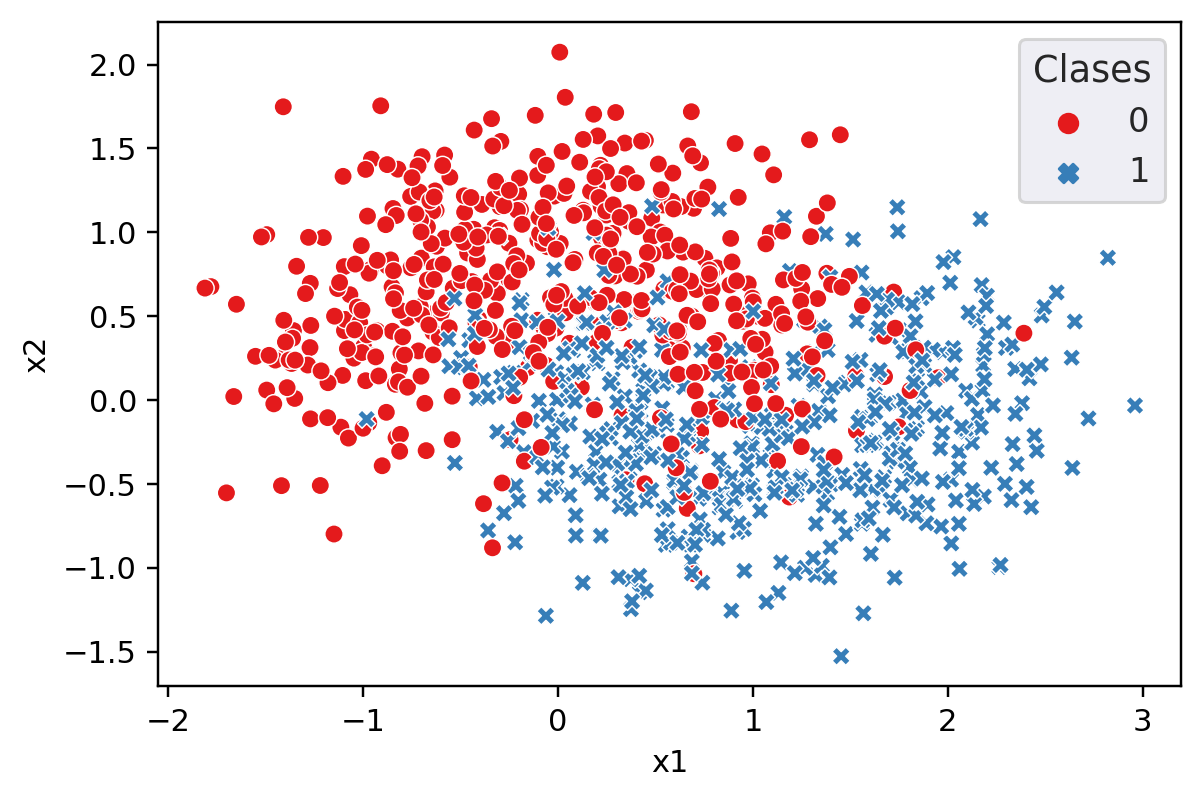

In [ ]:
plot_data(X, y)

A continuación, vamos a dividir el conjunto en $70\%$ para entrenamiento y $30\%$ para prueba. Utilizaremos el parámetro **`stratify`** para estratificar en submuestras balanceadas.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

Vamos a verificar el número de muestras de ambas particiones y la distribución de clases de cada una.

In [ ]:
print(f'Número de muestras en entrenamiento: {X_train.shape[0]}')
print(f'Número de muestras en prueba: {X_test.shape[0]}')
print(f'Número de características: {X_train.shape[1]}')

print(f'Distribución de clases en entrenamiento: {np.bincount(y_train)}')
print(f'Distribución de clases en prueba: {np.bincount(y_test)}')

Número de muestras en entrenamiento: 700
Número de muestras en prueba: 300
Número de características: 2
Distribución de clases en entrenamiento: [350 350]
Distribución de clases en prueba: [150 150]


# **3. Parámetros e Hiperparámetros**
---
Los **parámetros** o pesos de un modelo se refieren a los valores que caracterizan un modelo. Por ejemplo, en una regresión lineal los parámetros del modelo corresponden a los coeficientes por los cuales se multiplican las variables de entrada. Los parámetros son aprendidos por el algoritmo de aprendizaje a partir de los datos.

Por otra parte, los **hiperparámetros** son todos los parámetros que no se aprenden y que controlan el aprendizaje y el comportamiento del modelo. Estos son especificados de forma manual por el programador en la concepción del modelo.

Para entender la diferencia entre parámetros e hiperparámetros vamos a ver un ejemplo con uno de los modelos de clasificación más simples: la regresión logística.

El modelo de regresión logística busca clasificar los datos de forma binaria en dos categorías ($0$ y $1$). Para ello, usa la función logística o sigmoidal:

$$
\hat{y} = \frac{1}{1+e^{-\mathbf{w}\cdot\mathbf{x}+w_0}}
$$

Donde $\hat{y}$ es la *predicción*, $\mathbf{w}$ y $w_0$ son los *parámetros* y $\mathbf{x}$ es una *observación* o un vector de características que representa cada ejemplo.

Ahora vamos a definir un modelo de regresión logística en _Scikit-Learn_:

In [ ]:
# Importamos el modelo de sklearn.
from sklearn.linear_model import LogisticRegression

In [ ]:
# Definimos el modelo.
model_1 = LogisticRegression()

Hasta este punto ya tenemos definido el modelo, podríamos pasar a entrenarlo y posteriormente obtener predicciones sobre datos nuevos. No obstante, podemos definir otro modelo de regresión logística con algunas variaciones:

In [ ]:
# Definimos el segundo modelo
model_2 = LogisticRegression(fit_intercept=False)

Aunque el modelo **`model_2`** es un modelo de regresión logística, su comportamiento va a ser diferente al tener una variación en el hiperparámetro **`fit_intercept`**. Este especifica si el modelo va a tener en cuenta el intercepto $w_0$. Este segundo modelo se describiría por medio de la siguiente ecuación:

$$
\hat{y} = \frac{1}{1+e^{-{w}\cdot\mathbf{x}}}
$$

Este hiperparámetro afecta la forma del modelo, ya que tiene un parámetro menos.

Veamos la diferencia entre el comportamiento de los dos modelos definidos en el conjunto de datos artificial *blobs*:

In [ ]:
X_blobs, y_blobs = datasets.make_blobs(n_samples = 200, centers = 2,  random_state= 246)

In [ ]:
# Entrenamos el modelo 1.

model_1.fit(X_blobs, y_blobs)

LogisticRegression()

In [ ]:
# Entrenamos el modelo 2.

model_2.fit(X_blobs, y_blobs)

LogisticRegression(fit_intercept=False)

Podemos ver los parámetros de los dos modelos. Estos pueden ser accedidos con los atributos **`coef_`** (vector de pesos del modelo $w$)  e **`intercept_`** (intercepto $w_0$).

In [ ]:
# Vector w de pesos e intercepto w_0 del modelo 1.
print(f"Pesos w: {model_1.coef_}")
print(f"Intercepto w_0: {model_1.intercept_}")

Pesos w: [[ 0.94962826 -1.54776072]]
Intercepto w_0: [6.36160649]


In [ ]:
# Vector w de pesos e intercepto w_0 del modelo 2.
print(f"Pesos w: {model_2.coef_}")
print(f"Intercepto w_0: {model_2.intercept_}")

Pesos w: [[ 2.08605019 -0.83988412]]
Intercepto w_0: [0.]


Como podemos ver, el segundo modelo tiene $w_0=0$ y esto afecta los valores del vector de pesos ${w}$. Así mismo, afecta todo el aprendizaje y los resultados obtenidos.

A partir de la siguiente visualización podemos ver que la línea que separa las regiones de decisión del modelo pasa por el punto $(0, 0)$ cuando no se considera el intercepto en el entrenamiento del modelo.

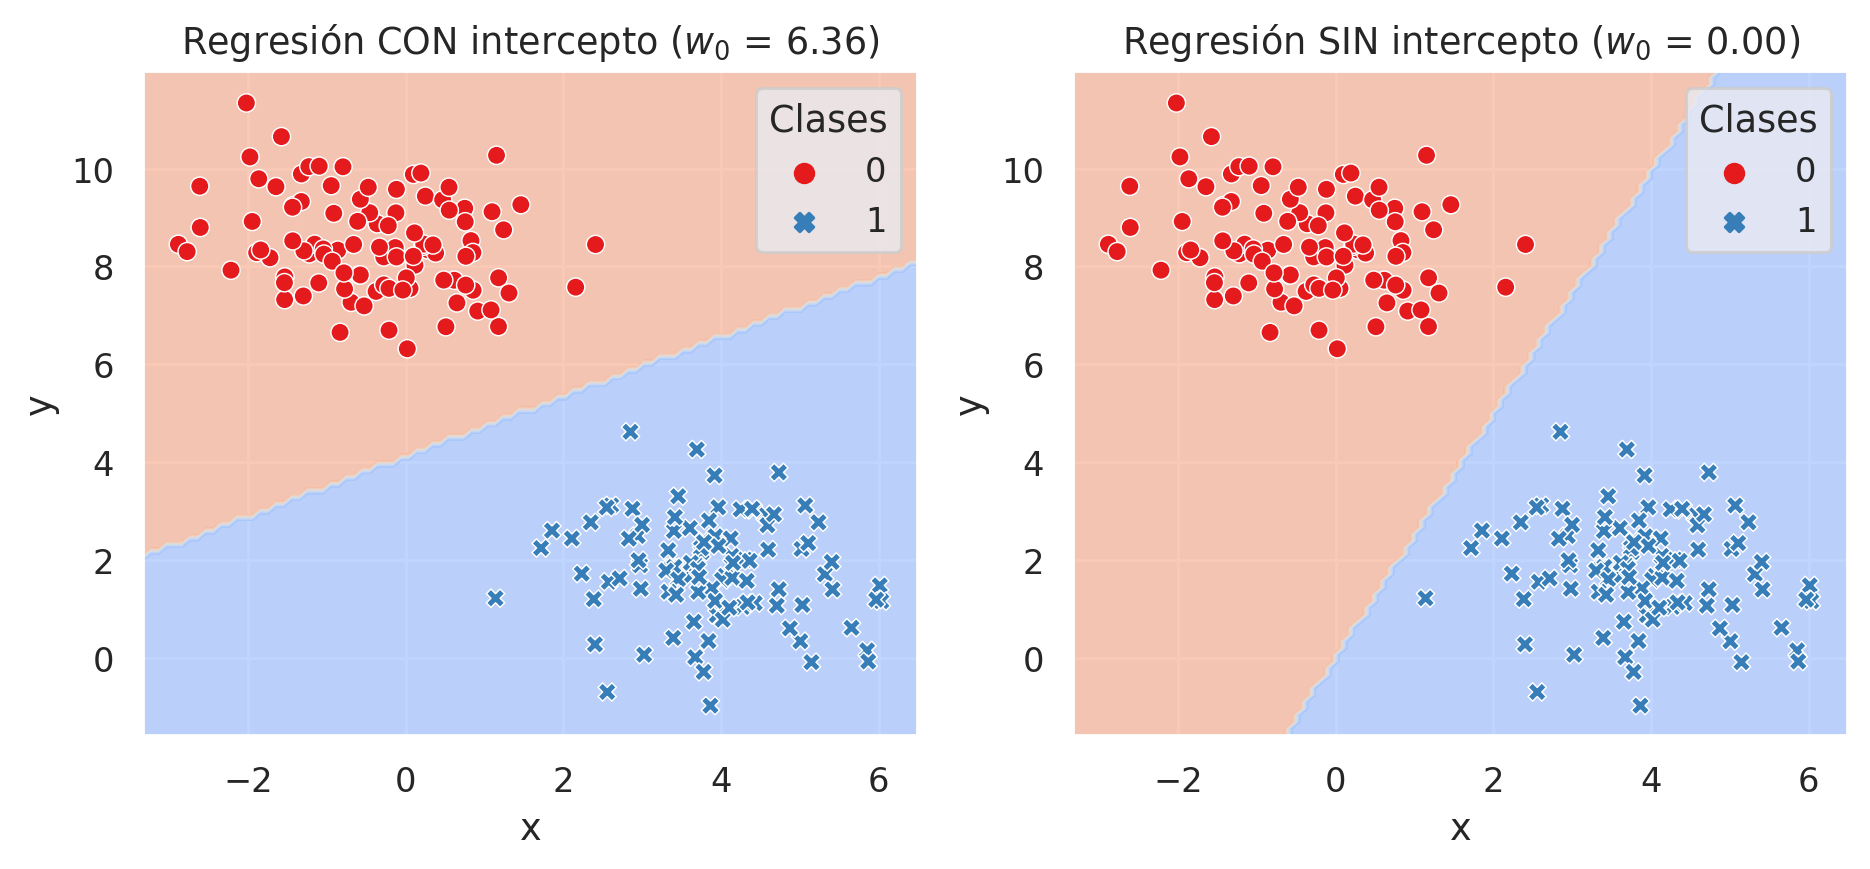

In [ ]:
fig, axes = plt.subplots(ncols = 2, dpi = 110, figsize = (10, 4))

plot_data(X_blobs, y_blobs, model_1, ax = axes[0], 
          title = f'Regresión CON intercepto ($w_0$ = {model_1.intercept_[0]:.2f})')
plot_data(X_blobs, y_blobs, model_2, ax = axes[1], 
          title = f'Regresión SIN intercepto ($w_0$ = {model_2.intercept_[0]:.2f})')


En general, en _Scikit-Learn_ los hiperparámetros se encuentran entre los argumentos requeridos para la definición del modelo. Veamos los argumentos de la regresión logística:

In [ ]:
model_1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Encontramos algunos hiperparámetros como:

* **`fit_intercept`**: especifica si el modelo utiliza el intercepto $w_0$.
* **`class_weight`** permite ponderar cada clase de acuerdo a un peso determinado.
* **`penalty`**: función de pérdida usada para la regularización del modelo. Es una restricción que se agrega sobre la función de pérdida que permite optimizar el modelo de regresión logística.
* **`tol`**: tolerancia mínima en la función de pérdida para detener el entrenamiento.
* **`solver`**: algoritmo de optimización que se utilizará para el entrenamiento.

Finalmente, veamos el efecto de variar el parametro **`class_weight`** con diferentes valores en la regresión logística:

In [ ]:
# Definimos una serie de valores para el peso de la clase 0.
weights = np.linspace(0, 1, 5)
weights

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [ ]:
# Definimos una figura con 5 ejes
fig, ax = plt.subplots(nrows = 5, figsize=(6, 20), dpi = 110)

# Iteramos para cada peso a explorar
for i, weight in enumerate(weights):
    # Definimos un modelo para el valor de 'class_weight' actual.    
      # El parámetro 'class_weight' es recibido en
      # forma de diccionario con el peso dado por
      # cada clase en 'y'.
    model = LogisticRegression(class_weight= {0: weight, 1: 1 - weight})

    # Entrenamos el modelo
    model.fit(X_train, y_train)
    # Mostramos la región de decisión y los puntos con sus etiquetas.
    plot_data(X_train, y_train, model = model, ax=ax[i], title=f"Pesos por clase: [Clase 0: {weight}; Clase 1: {1 - weight}]")

fig.tight_layout()

> **¿Observa alguna diferencia?**

Conforme los pesos varían en el rango $[0, 1]$ la región de decisión tiende a predecir una mayor cantidad de datos para la clase con mayor peso.

# **4. Capacidad de un modelo**
---
La capacidad o complejidad de un modelo es su habilidad de ajustarse a una amplia variedad de funciones.

Una forma de controlar la capacidad de un algoritmo de aprendizaje es elegir su espacio de hipótesis, el conjunto de funciones que puede seleccionar como la solución. 


Por ejemplo, en un modelo de regresión polinomial la capacidad se puede controlar especificando el máximo grado $d$ del polinomio que se puede aprender. A mayor grado $d$ más grande el espacio de hipótesis y por lo tanto mayor capacidad. 


<img src="https://drive.google.com/uc?export=view&id=1li2VAfipUxUoIcJ_7W_KJ51QGrnZioNx" width=400>

En el lado izquierdo de la gráfica, ambos errores son altos, esta es la zona que corresponde al **subajuste**. A medida que aumentamos la capacidad, el error de entrenamiento se reduce, pero la brecha de generalización aumenta. 

Eventualmente, el tamaño de la brecha supera la disminución del error de entrenamiento, y se entra a la zona de sobreajuste, donde la capacidad es muy alta, por encima de la capacidad óptima. 



# **5. Subajuste, Sobreajuste y ajuste apropiado.**
---
Un algoritmo de aprendizaje automático busca cumplir los siguientes objetivos:

- Hacer que el error de entrenamiento sea bajo.
- Hacer que la brecha entre el error de entrenamiento y el error de prueba sea pequeña.

Dependiendo del desempeño del algoritmo en estas dos habilidades se habla de que el modelo resultante tiene **subajuste**, **sobreajuste** o **ajuste apropiado**.


## **6.1 Sobreajuste**
---
<img src="https://drive.google.com/uc?export=view&id=1yLVxXHJfQfDOdsr7moiqumtFvp9U1K1L" width=300>

El sobreajuste (*overfitting* en inglés) ocurre cuando la brecha entre el error de entrenamiento y el error de prueba es muy grande. En estos casos el error de entrenamiento es bajo, pero el error de generalización es alto. Este resultado indica que el modelo se sobreajusta a los detalles más granulares de los datos de entrenamiento.



Para ejemplificar este concepto, utilizaremos el algoritmo K-vecinos más cercanos (*KNN*). Usamos la partición de entrenamiento y prueba creada y analizaremos un modelo _KNN_ entrenado con $k = 1$.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

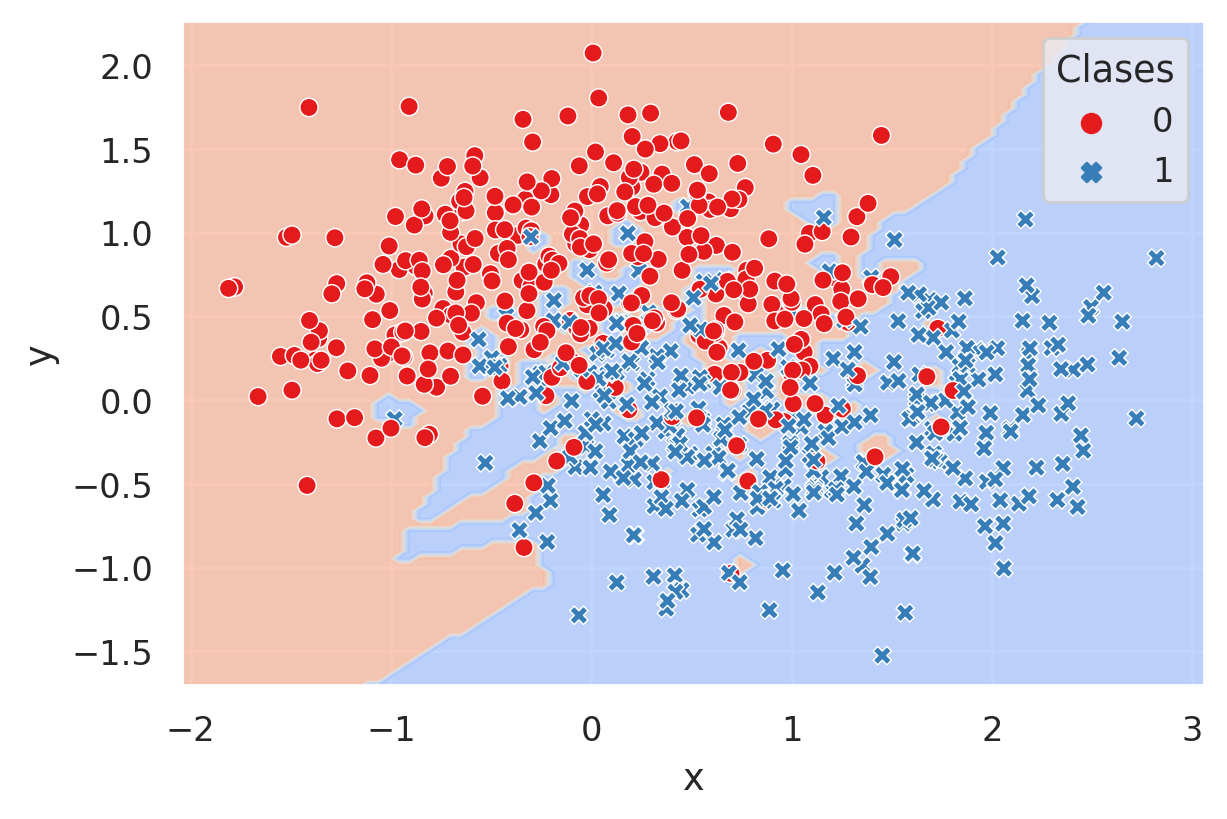

In [ ]:
plot_data(X_train, y_train, model = knn)

In [ ]:
print("Error en entrenamiento:", 1 - knn.score(X_train, y_train))

Error en entrenamiento: 0.0


> **¿Tiene sentido que el error sea del $0\%$?**

Revisemos el desempeño en la partición de prueba:

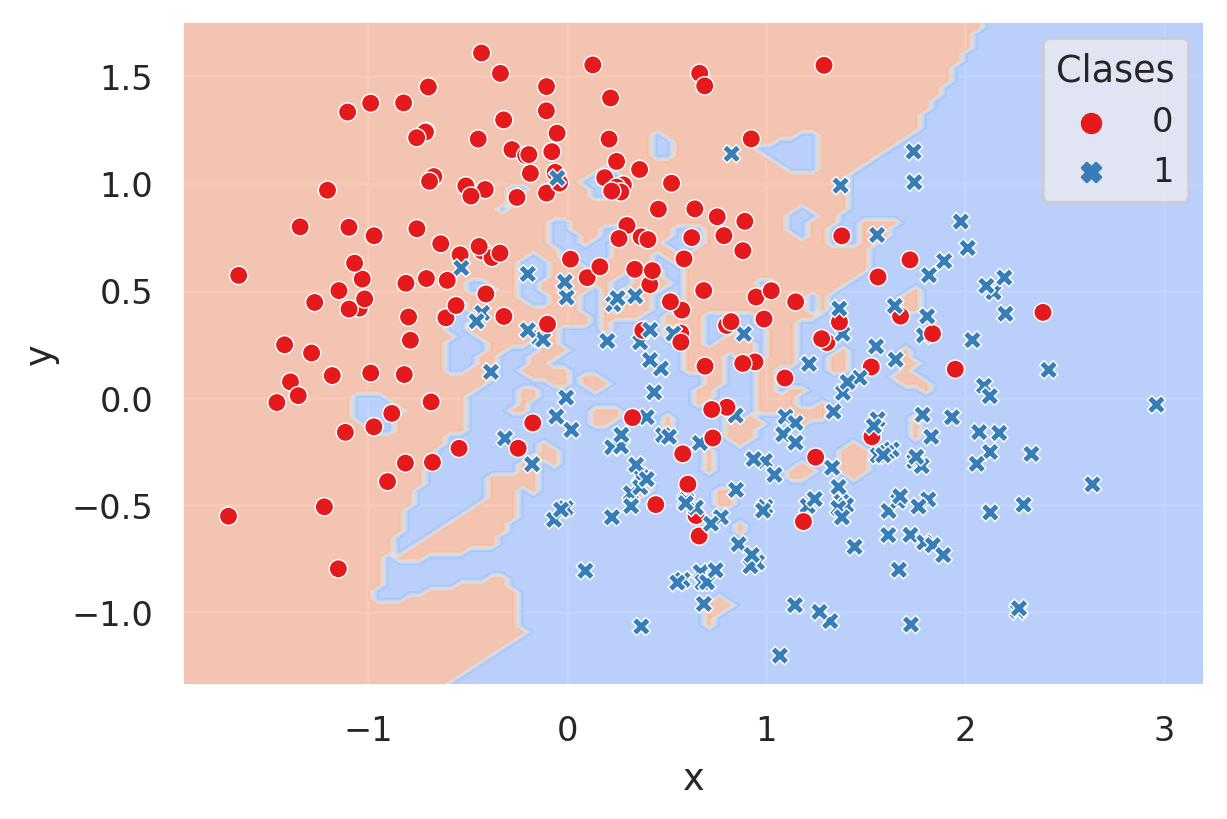

In [ ]:
plot_data(X_test, y_test, model = knn)

In [ ]:
print('Error en prueba:', 1 - knn.score(X_test, y_test))

Error en prueba: 0.21333333333333337


Podemos observar que cuando el número de vecinos es $1$, el modelo se ajusta demasiado al ruido de los datos de entrada y por lo tanto sufre de **sobreajuste**.

## **6.2 Subajuste**
---

<img src="https://drive.google.com/uc?export=view&id=1xdKPb1Oz22HghkmnQPgX8DOqllZYB2lG" width=300>

El subajuste (*underfitting* en inglés) ocurre cuando el modelo no logra conseguir un error de entrenamiento (ni de generalización) suficientemente bajo.

Este resultado ocurre porque el modelo no tiene la capacidad suficiente para capturar la estructura de los datos y el problema.




Usaremos la partición creada y analizaremos un modelo _KNN_ entrenado con $k = 400$.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=400)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=400)

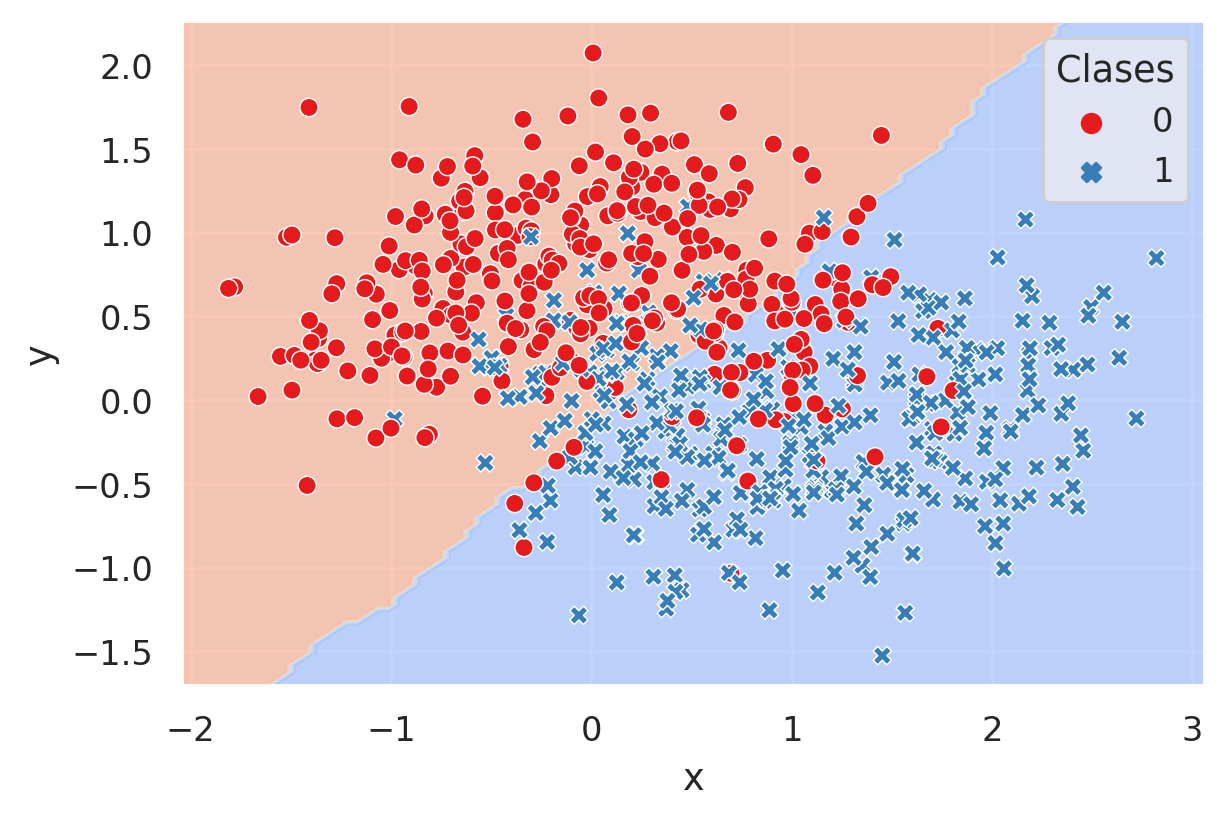

In [ ]:
plot_data(X_train, y_train, model = knn)

In [ ]:
print('Error en entrenamiento:', 1-knn.score(X_train, y_train))

Error en entrenamiento: 0.18999999999999995


Observamos que el error en entrenamiento es del $19\%$. El modelo entrenado es ahora demasiado **simple** y no se puede ajustar a la estructura de los datos.

Ahora medimos el error de generalización del modelo entrenado y visualizamos la clasificación de los datos de prueba.

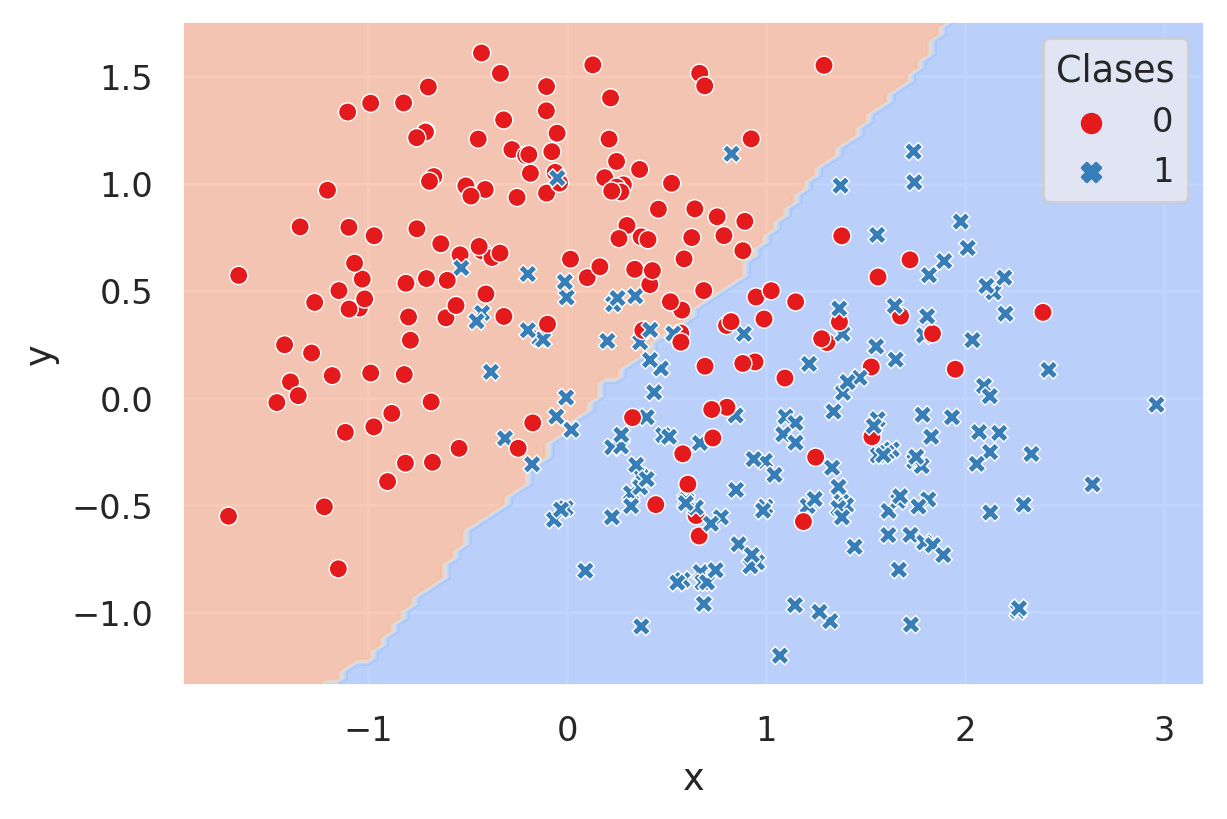

In [ ]:
plot_data(X_test, y_test, model = knn)

In [ ]:
print('Error de generalización:', 1 - knn.score(X_test, y_test))

Error de generalización: 0.18999999999999995


Podemos observar que cuando aumentamos el número de vecinos, nuestro modelo sufre de **subajuste**. La superficie de decisión se suaviza, pero no logra captar los detalles de los datos. Tanto el error de entrenamiento como el error de generalización se acercan a $19\%$.

**¿Cómo estimar un buen número de $k$-vecinos más cercanos de manera que el modelo no sobreajuste ni subajuste los datos?**

### **6.3 Ajuste Apropiado**
---

<img src="https://drive.google.com/uc?export=view&id=1GE36PB3mBa9_76v0-jYdFFmHkm7Cng7G" width=300>

El ajuste apropiado ocurre cuando tanto el error de entrenamiento y el de generalización son bajos. En este caso el modelo logra comportarse de manera similar tanto en el conjunto de entrenamiento como en el conjunto de prueba con un desempeño es satisfactorio.

En la siguiente subsección veremos un ejemplo de cómo encontrar el valor de $k$ para encontrar la complejidad óptima.

### **6.3.1. Determinación de la complejidad óptima para _KNN_**
---

Un modelo de aprendizaje de máquina puede ser tan complejo como para recordar las particularidades y el ruido del conjunto de entrenamiento (**sobreajuste**), así como puede ser demasiado flexible para no modelar la variabilidad de los datos (**subajuste**). El modelo debe garantizar un compromiso entre el sobreajuste y el subajuste, lo cual se logra evaluando la complejidad del modelo. Una forma de evaluar la complejidad es analizar el error de entrenamiento y generalización para diferentes modelos que varían en su complejidad. En el caso de **`KNearestNeighbor`**, la complejidad está determinada por el número de vecinos $k$. **Entre menor sea el número de vecinos, más complejo es el modelo.**

A continuación, exploramos un conjunto de valores $k$, con el objetivo de encontrar aquél modelo con el mejor compromiso entre error de entrenamiento y error de generalización.

In [ ]:
k_values = 50

Evaluamos el error de entrenamiento y generalización para diferentes valores de complejidad del modelo:

In [ ]:
train_error = []
generalization_error = []

for nn in range(1, k_values + 1):
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    generalization_error.append(1 - knn.score(X_test, y_test))

Visualizamos ambas curvas de aprendizaje.

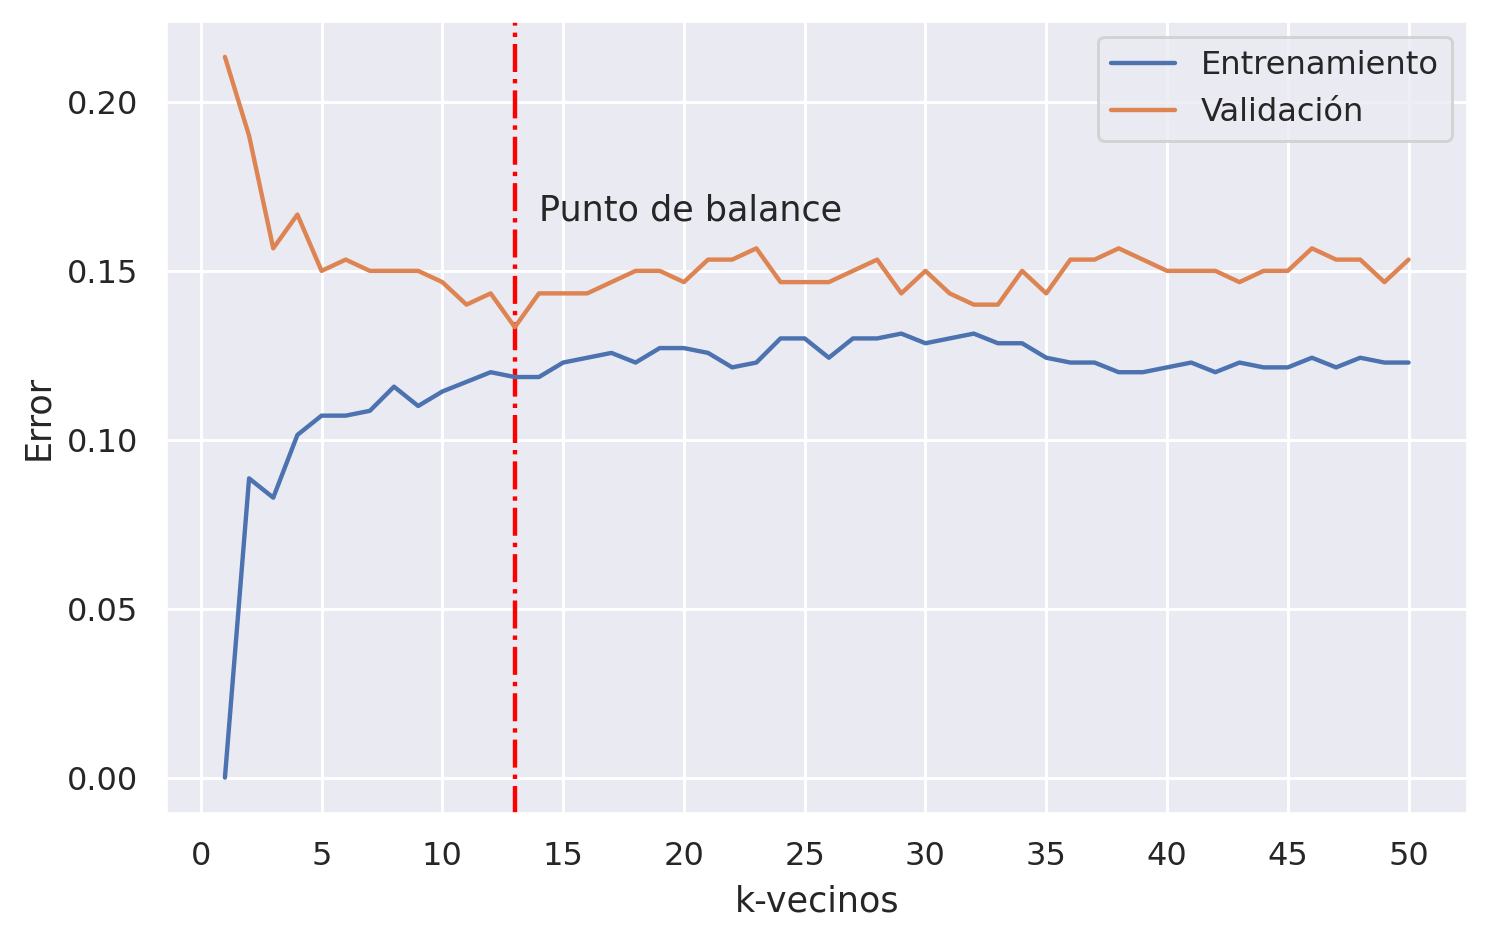

In [ ]:
plot_learning_curve(train_error, generalization_error)

Se observa que el error de entrenamiento es más alto para modelos más simples (valor de $k$ alto) y tiende a cero para modelos más complejos (valor bajo de $k$). Además, el error de validación es alto en ambos extremos, y tiene su punto de balance mínimo en $k=13$. 

In [ ]:
print("Error de generalización con k = 13:", generalization_error[12])

Error de generalización con k = 13: 0.1333333333333333




Tenga en cuenta que a comparación de la gráfica en la **sección 4**, está gráfica está invertida, pues, KNN tiene mayor complejidad con menor número de vecinos a considerar.

A continuación, se muestra la frontera de decisión para el clasificador con número de vecinos $k=13$. 

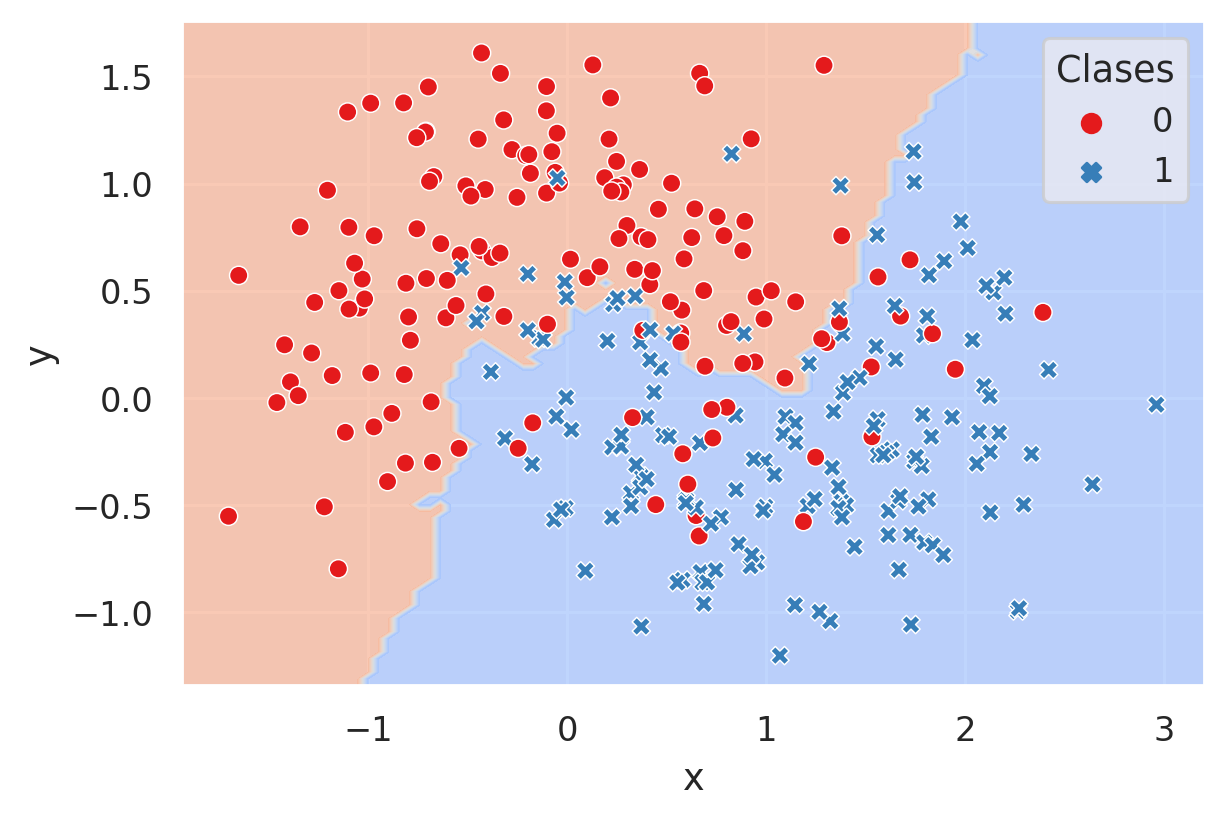

In [ ]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)

plot_data(X_test, y_test, knn)

# **Recursos adicionales**
---
Los siguientes enlaces corresponden a sitios en donde encontrará información muy útil para profundizar en el conocimiento de las funcionalidades de la librería *Scikit-learn* en la evaluación de la complejidad de sus modelos, además de material de apoyo teórico para reforzar estos conceptos:

- [Scikit-learn - Underfitting vs Overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)
- [Machine Learning Mastery - Overfitting and Underfitting with machine learning algorithms](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/)
- [Deep Learning Book - Chapter 5 - Machine Learning Basics](https://www.deeplearningbook.org/contents/ml.html)
- [Elite Data Science - Overfitting in Machine Learning](https://elitedatascience.com/overfitting-in-machine-learning)

# **Créditos**
---

* **Profesor:** [Fabio Augusto González](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:** 
  * Miguel Angel Ortiz Marín
  * Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*